![](../img/330-banner.png)

# Lecture 15: K-Means Clustering 

UBC 2024-25

## Imports and learning outcomes 

### Imports

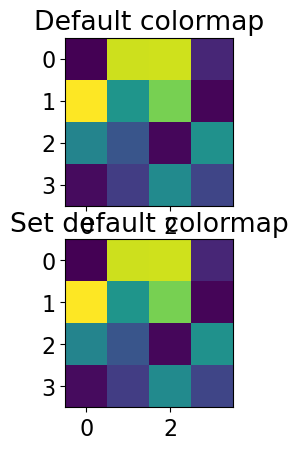

In [1]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.path.abspath(".."), "code"))
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from plotting_functions import *
from plotting_functions_unsup import *
from sklearn import cluster, datasets, metrics
from sklearn.datasets import make_blobs
import mglearn
#plt.style.use("seaborn")

plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (5, 4)

import warnings
warnings.filterwarnings("ignore")

### Learning outcomes

From this lecture, students are expected to be able to:

- Explain the unsupervised paradigm. 
- Explain the motivation and potential applications of clustering. 
- Define the clustering problem. 
- Broadly explain the K-Means algorithm apply `sklearn`'s `KMeans` algorithm.  
- Point out pros and cons of K-Means and the difficulties associated with choosing the right number of clusters.   
- Create the Elbow plot and Silhouette plots for a given dataset. 
- Use clustering for the problem of image clustering and interpret clusters. 
- Demonstrate how input data representation can influence clustering results. 

## Introduction to unsupervised learning

### Types of machine learning 

Recall the typical learning problems we discussed in 571. 

- Supervised learning ([Gmail spam filtering](https://support.google.com/a/answer/2368132?hl=en))
    - Training a model from input data and its corresponding targets to predict targets for new examples. 
- **Unsupervised learning** (this course) ([Google News](https://news.google.com/))
    - Training a model to find patterns in a dataset, typically an unlabeled dataset.
- Reinforcement learning ([AlphaGo](https://deepmind.com/research/case-studies/alphago-the-story-so-far))
    - A family of algorithms for finding suitable actions to take in a given situation in order to maximize a reward. 
- **Recommendation systems** ([Amazon item recommendation system](https://www.cs.umd.edu/~samir/498/Amazon-Recommendations.pdf))
    - Predict the "rating" or "preference" a user would give to an item.    

### Supervised learning

- Training data comprises a set of observations ($X$) and their corresponding targets ($y$). 
- We wish to find a model function $f$ that relates $X$ to $y$.
- Then use that model function to predict the targets of new examples.
- We have been working with this set up so far. 

![](../img/sup-learning.png)

<!-- <img src="img/sup-learning.png" height="1000" width="1000">  -->

### Unsupervised learning

- Training data consists of observations ($X$) without any corresponding targets.
- Unsupervised learning could be used to group similar things together in $X$ or to find underlying structure in the data. 

![](../img/unsup-learning.png)

<!-- <img src="img/unsup-learning.png" alt="" height="900" width="900">  -->

### Can we learn without targets?

- Yes, but the learning will be focused on finding the underlying structures of the inputs themselves (rather than finding the function $f$ between input and output like we did in supervised learning models). 

- Examples:
    - Clustering (this course)
    - Dimensionality reduction (requires some math, not covered in this course)

### Labeled vs. Unlabeled data
- If you have access to labeled training data, you're in the "supervised" setting. 
- You know what to do in that case from the previous lectures
- Unfortunately, getting large amount of labeled training data is often time consuming and expensive.
- Annotated data can become "stale" after a while in cases such as fraud detection. 
- Can you still make sense of the data even though you do not have the labels? 
- Yes! At least to a certain extent! 

### Example: Supervised vs unsupervised learning

- In supervised learning, we are given features $X$ and target $y$. 


<table>
<tr style="background-color:white;">
    <td>
        <table>
            <tr>
                <td colspan="2" style="text-align:center;"> <b>Dataset 1</b> </td>
                <td></td>
            </tr>
            <tr>
                <td>$x_1$</td>
                <td>$y$</td>
            </tr>
            <tr>
                <td> 101.0
                <td> Sick
            </tr>
            <tr>
                <td> 98.5 
                <td> Not Sick
            </tr>
            <tr>
                <td> 93.8 
                <td> Sick
            </tr>
            <tr>
                <td> 104.3
                <td> Sick
            </tr>
            <tr>
                <td> 98.6 
                <td> Not Sick
            </tr>
        </table>
    </td>
    <td>
       <table>
            <tr>
                <td colspan="3" style="text-align:center;"> <b>Dataset2</b> </td>
                <td></td>
            </tr>
            <tr>
                <td>$x_1$</td>
                <td>$x_2$</td>
                <td>$y$</td>
            </tr>
            <tr>
                <td> -2.68
                <td> 0.32 
                <td>class 1
            </tr>
            <tr>
                <td> -2.71
                <td> -0.18
                <td> class 1
            </tr>
            <tr>
                <td> 1.28  
                <td> 0.69    
                <td> class 2
            </tr>
            <tr>
                <td> 0.93  
                <td> 0.32   
                <td> class 2
            </tr>
            <tr>
                <td> 1.39
                <td> -0.28 
                <td> class 3
            </tr>
        </table>
    </td>
</tr>
</table>

- In unsupervised learning, we are only given features $X$. 

<table>
<tr style="background-color:white;">
    <td>
        <table>
            <tr>
                <td colspan="2" style="text-align:center;"> <b>Dataset 1</b> </td>
                <td></td>
            </tr>
            <tr>
                <td>$x_1$</td>
            </tr>
            <tr>
                <td> 101.0
            </tr>
            <tr>
                <td> 98.5 
            </tr>
            <tr>
                <td> 93.8 
            </tr>
            <tr>
                <td> 104.3
            </tr>
            <tr>
                <td> 98.6 
            </tr>
        </table>
    </td>
    <td>
       <table>
            <tr>
                <td colspan="3" style="text-align:center;"> <b>Dataset 2</b> </td>
                <td></td>
            </tr>
            <tr>
                <td>$x_1$</td>
                <td>$x_2$</td>
            </tr>
            <tr>
                <td> -2.68
                <td> 0.32 
            </tr>
            <tr>
                <td> -2.71
                <td> -0.18
            </tr>
            <tr>
                <td> 1.28  
                <td> 0.69    
            </tr>
            <tr>
                <td> 0.93  
                <td> 0.32   
            </tr>
            <tr>
                <td> 1.39
                <td> -0.28 
            </tr>
        </table>
    </td>
</tr>
</table>

<br><br><br><br>

## Clustering Activity (~5 mins)

![](../img/food-clustering-activity.png)

- Categorize the food items in the image and write your categories. Do you think there is one correct way to cluster these images? Why or why not?
- If you want to build a machine learning model to cluster such images how would you represent such images?

<br><br><br>

## Clustering motivation [[video](https://youtu.be/caAuUAXwpb8)]

### The "perfect" spaghetti sauce

Suppose you are a hypothetical spaghetti sauce company and you're asked to create the "perfect" spaghetti sauce which makes all your customers happy. The truth is humans are diverse and there is no "perfect" spaghetti sauce. There are "perfect" spaghetti sauces that cater to different tastes! 

Howard Moskowitz found out that Americans fall into one of the following three categories: 
- people who like their spaghetti sauce **plain**
- people who like their spaghetti sauce **spicy**
- people who like their spaghetti sauce **extra chunky**

![](../img/prego-pasta-sauces.png)

If one “perfect” authentic sauce satisfies 60%, of the people on average, creating several tailored sauce clusters could increase average happiness to between 75% to 78%.

Can we apply this concept of clustering and tailoring solutions to specific groups in machine learning?

Reference: [Malcolm Gladwell’s Ted talk](https://www.ted.com/talks/malcolm_gladwell_choice_happiness_and_spaghetti_sauce?language=en)

<br><br>

### What is clustering? 

- Most of the data out there is unlabeled.  
- Getting labeled training data is often difficult, expensive, or simply impossible in some cases. 
- Can we extract some useful information from unlabeled data? 
- The most intuitive way is to group similar examples together to get some insight into the data even though we do not have the targets.  


**Clustering** is the task of partitioning the dataset into groups called clusters based on their similarities.

The goal of clustering is to discover underlying groups in a given dataset such that:
- examples in the same group are as similar as possible;
- examples in different groups are as different as possible.          

<br><br>

### Clustering: Input and (possible) output

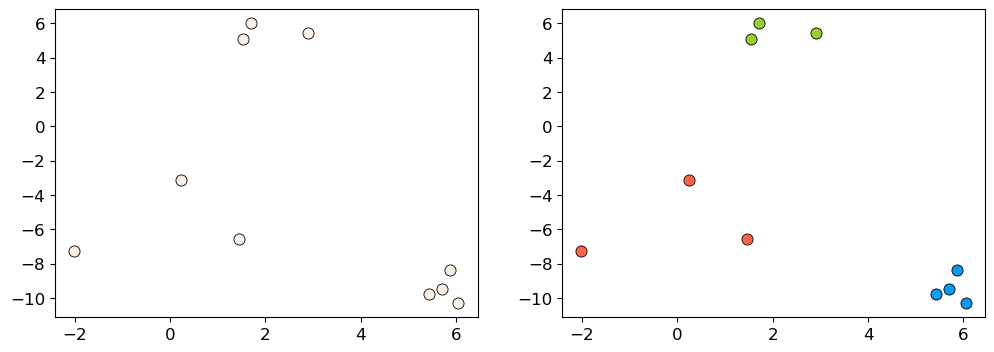

In [2]:
X, y = make_blobs(n_samples=10, centers=3, n_features=2, random_state=10)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
discrete_scatter(X[:, 0], X[:, 1], ax = axes[0]); # user-defined plotting function defined in code/plotting_functions.py
discrete_scatter(X[:, 0], X[:, 1], y=y, markers='o', ax = axes[1]);

One way to think of clustering is the task of colouring the given set of points (e.g., blue, red, green) such that points with the same color are close to each other. 

- Usually the clusters are identified by a **cluster label**. 
- These labels are arbitrary, and relabeling the points (label switching) does not make a difference. 
- What we care about is which points have the same labels and which ones have different labels. 
- Very often we do not know how many clusters are there in the data or if there are any clusters at all. In real-world data, clusters are rarely as clear as in our toy example above. 
- There is a notion of coherent and semantically meaningful clusters in some sense but there is no absolute truth here. 

#### Example 1: What is "correct" grouping?
Which of the following grouping of emoticons is the "correct" grouping?

![](../img/emoticon_clustering_example.png)

<!-- <img src="img/emoticon_clustering_example.png" alt="" height="800" width="800">  -->

Both seem reasonable! 

- In clustering, meaningful groups are dependent on the **application**.
- It usually helps if we have some prior knowledge about the data and the problem.   
- This makes it hard for us to objectively measure the quality of a clustering algorithm (or think about "true" clusters).

<br><br>

### Common applications

#### Data exploration
Although there is no notion of the "right" answer, we might still get something useful out of clustering. There are a number of common applications for clustering. 

- Summarize or compress data. 
- Partition the data into groups before further processing. 
- For instance, you could use it in supervised learning setting as follows. Carry out clustering and examine performance of your model on individual clusters. If the performance is lower on a particular cluster, you could either try building a separate model for that cluster and improve the overall performance of your supervised model. 

#### Customer segmentation

- Understand landscape of the market in businesses and craft targeted business or marketing strategies tailored for each group.

![](../img/customer-segmentation.png)

<!-- <img src="img/customer-segmentation.png" alt="" height="600" width="600">  -->

[source](https://www.youtube.com/watch?v=zPJtDohab-g&t=134s)

#### Document clustering

Grouping articles on different topics from different news sources. For example, [Google News](https://news.google.com). 

![](../img/google_news.png)

<!-- <img src="img/google_news.png" alt="" height="1200" width="1200">  -->
    
**You'll be working on document clustering, image clustering, and multimodal clustering in the lab.**

### Other applications
- Social network analysis
- Medical imaging (image segmentation, image grouping, anomaly detection)
- Imputing missing data, data compression, privacy preservation 

<br><br><br><br><br><br>

## K-Means clustering [[video](https://youtu.be/s6AvSZ1_l7I)]

- Clustering is based on the notion of similarity or distances between points. 
- How do we determine similarity between points in a multi-dimensional space?
- Can we use something like $k$-neighbours for similarity? 
    - Yes! That's a good start!  
    - With $k$-neighbours we used Euclidean distances to find nearby points. 
    - We can use the same idea for clustering! 

K-Means is one of the most commonly used clustering algorithms. 

**Input**
- `X` $\rightarrow$ a set of data points  
- `K` (or $k$ or `n_clusters`) $\rightarrow$ number of clusters

**Output**
- `K` clusters (groups) of the data points 



- Before understanding the algorithm, let's try it with `sklearn`. 
- Consider the toy dataset above. 
- For this toy dataset, the three clusters are pretty clear.  

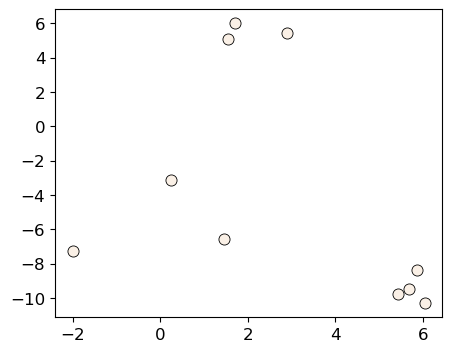

In [3]:
X, y = make_blobs(n_samples=10, centers=3, n_features=2, random_state=10)
discrete_scatter(X[:, 0], X[:, 1]);

Let's try `sklearn`'s `KMeans` algorithm on this dataset.

- First, let's decide how many clusters we want. 
- Let's pass `n_clusters = 3` in this toy dataset. 
- When we call `fit`, we are only passing `X` because this is unsupervised learning; we do not have labels.  

In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(X); # We are only passing X because this is unsupervised learning

- The output of `KMeans` is `n_clusters` clusters (groups) of the data points. 
- Calling `predict` on the `KMeans` object gives us the cluster assignment for each data point. 

In [5]:
clust_labels = kmeans.predict(X)
clust_labels

array([2, 1, 0, 1, 2, 2, 0, 0, 1, 2], dtype=int32)

We can also access these labels with the `labels_` attribute of `KMeans` object. 

In [6]:
kmeans.labels_

array([2, 1, 0, 1, 2, 2, 0, 0, 1, 2], dtype=int32)

In [7]:
toy_clust_df = pd.DataFrame(X, columns = ['feat1', 'feat2'])
toy_clust_df['cluster labels'] = clust_labels
toy_clust_df

,feat1,feat2,cluster labels
0,5.691924,-9.476412,2
1,1.707899,6.004352,1
2,0.236210,-3.119100,0
3,2.901595,5.421215,1
4,5.859439,-8.381924,2
5,6.047749,-10.305047,2
6,-2.007588,-7.247439,0
7,1.454677,-6.583872,0
8,1.536362,5.111215,1
9,5.430704,-9.759561,2


In K-Means each cluster is represented by its **cluster center**. Let's examine these cluster centers from the `kmeans` object above. 

In [8]:
cluster_centers = kmeans.cluster_centers_
cluster_centers

array([[-0.10556679, -5.65013704],
       [ 2.04861878,  5.51226051],
       [ 5.75745416, -9.48073598]])

Let's plot clustered data points and their corresponding centers. 

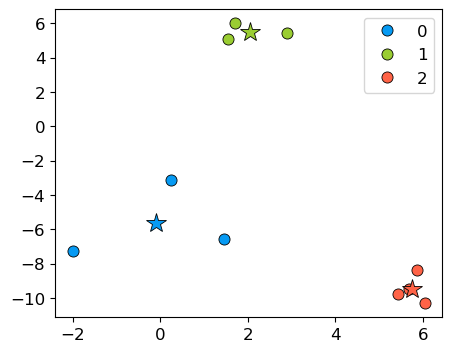

In [9]:
km_labels = kmeans.labels_
discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, c=kmeans.labels_, markers="o");
plt.legend();
discrete_scatter(cluster_centers[:, 0], cluster_centers[:, 1], y =[0,1,2], s=15, markers='*');

Cluster centers are shown with stars. They are the average of observations in a cluster and so not usually one of the data points. These centers are also referred to as **centroids**. 

With a fitted K-Means object, we can also use `predict` on unseen examples!  

Consider the two new query points shown with triangles below. 

In [10]:
new_examples = np.array([[-2, -2.5], [2, 4]])
kmeans.predict(new_examples)

array([0, 1], dtype=int32)

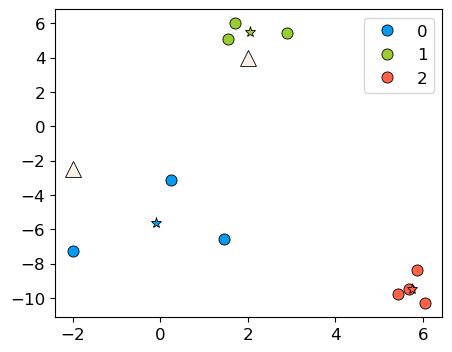

In [11]:
discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers="o")
plt.legend()
discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], y=[0,1,2], markers="*"
);
discrete_scatter(new_examples[:, 0], new_examples[:, 1], markers="^",s=11);

In [12]:
kmeans.predict(new_examples).tolist()

[0, 1]

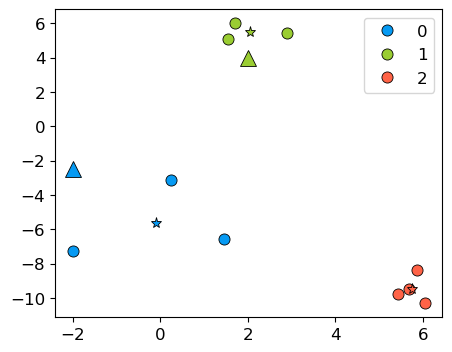

In [13]:
discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers="o")
plt.legend()
discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], y=[0,1,2], markers="*"
);
discrete_scatter(new_examples[:, 0], new_examples[:, 1], y=kmeans.predict(new_examples).tolist(), markers="^",s=11);

### K-Means algorithm

- The main idea is to represent each cluster by its cluster center and assign a cluster membership to each data point. 

**Chicken-and-egg problem!**

- If we knew cluster centers, we can simply assign each point to its nearest center.
- Similarly, if we knew assignments, we can calculate cluster centers.  
- But we do not know either 😟. 

A usual computer science answer to such problems is iterations!! 

Here is the overview of the algorithm. 

**Input**: Data points X and the number of clusters K

**Initialization**: K initial centers for the clusters

**Iterative process**:

repeat 
- Assign each example to the closest center.
- Estimate new centers as _average_ of observations in a cluster.

until **centers stop changing** or **maximum iterations have reached**.

<br><br><br>

### K-Means example
Let's execute K-Means algorithm on our toy example. 

**Input**
- The data points `X`

In [14]:
n_examples = X.shape[0]
print("Number of examples: ", n_examples)
X

Number of examples:  10


array([[  5.69192445,  -9.47641249],
       [  1.70789903,   6.00435173],
       [  0.23621041,  -3.11909976],
       [  2.90159483,   5.42121526],
       [  5.85943906,  -8.38192364],
       [  6.04774884, -10.30504657],
       [ -2.00758803,  -7.24743939],
       [  1.45467725,  -6.58387198],
       [  1.53636249,   5.11121453],
       [  5.4307043 ,  -9.75956122]])

- Let K (number of clusters) be 3. 

In [15]:
k = 3

**Initialization**

- Random initialization for K initial centers of the clusters. 

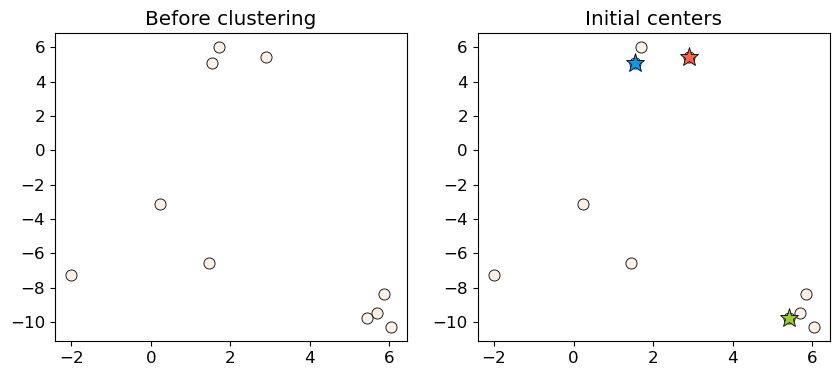

In [16]:
np.random.seed(seed=3)
centers_idx = np.random.choice(range(0, n_examples), size=k)
centers = X[centers_idx]
plot_km_initialization(X, centers) # user-defined plotting function defined in code/plotting_functions.py

**Iterative process**

repeat 

- Assign each example to the closest center. (`update_Z`)
- Estimate new centers as _average_ of observations in a cluster. (`update_centers`)

until **centers stop changing** or **maximum iterations have reached**.

- First step in the iterative process is assigning examples to the closest center. How to find closest centers? 
- Let's consider distance of an example to all centers and assign that example to the closest center.  


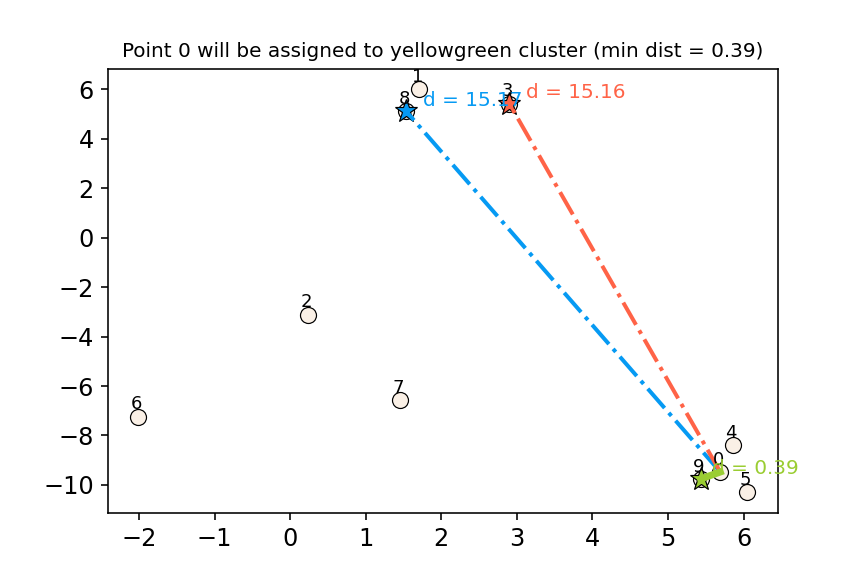
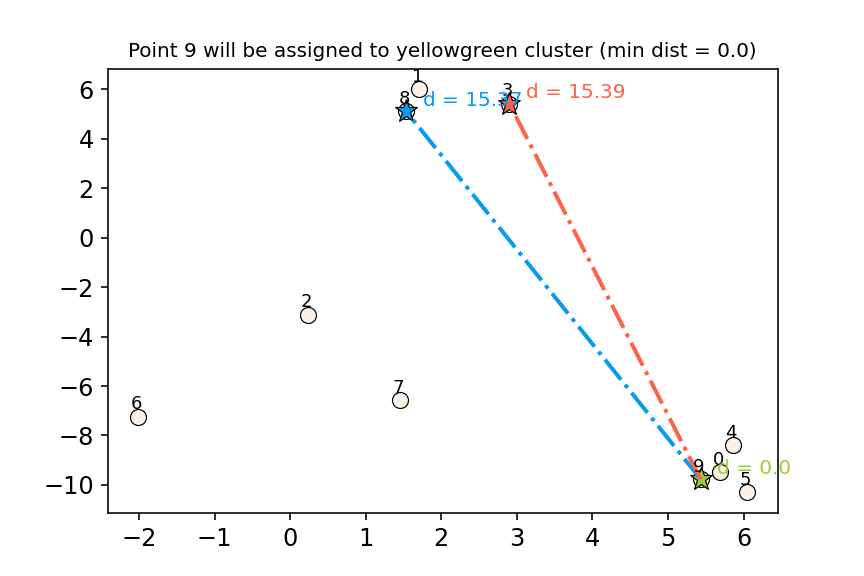
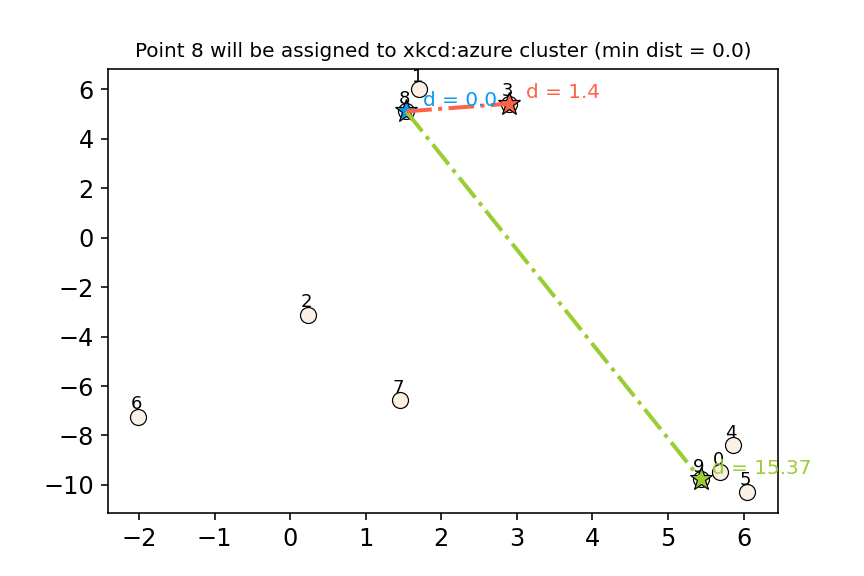
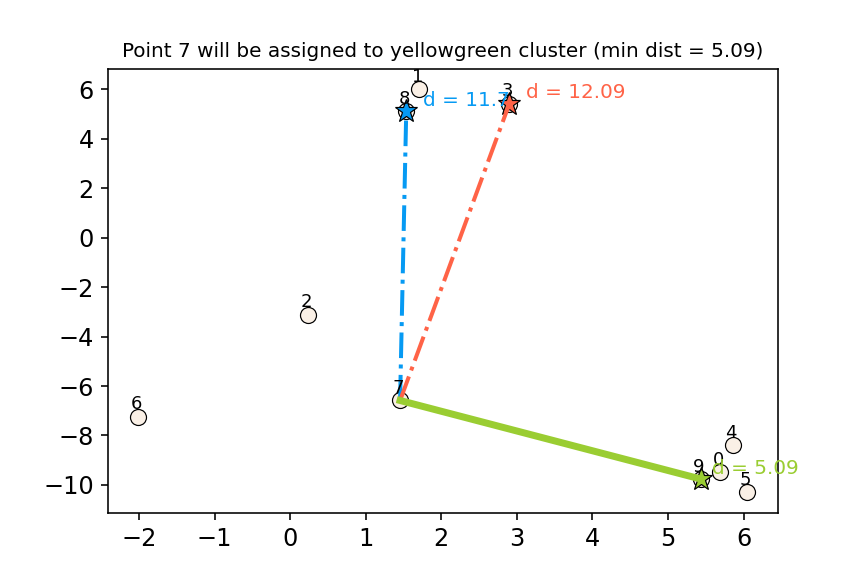
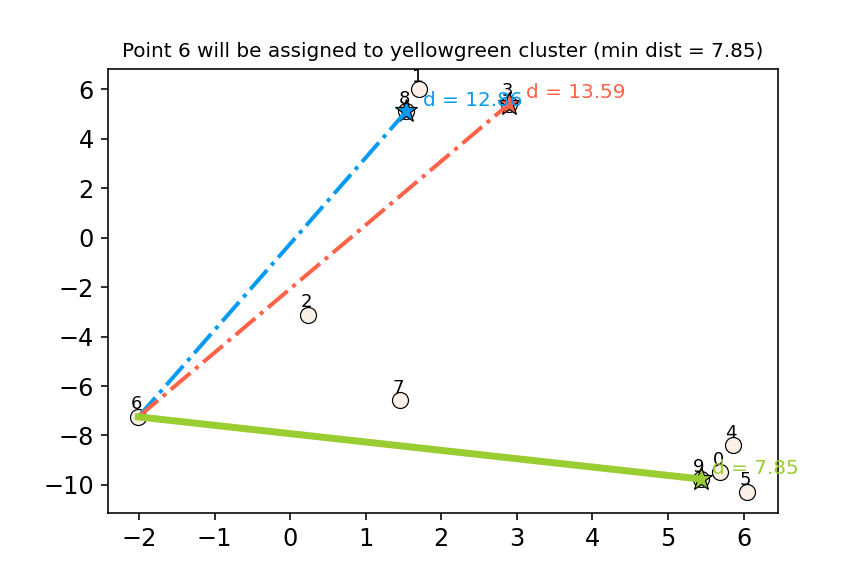
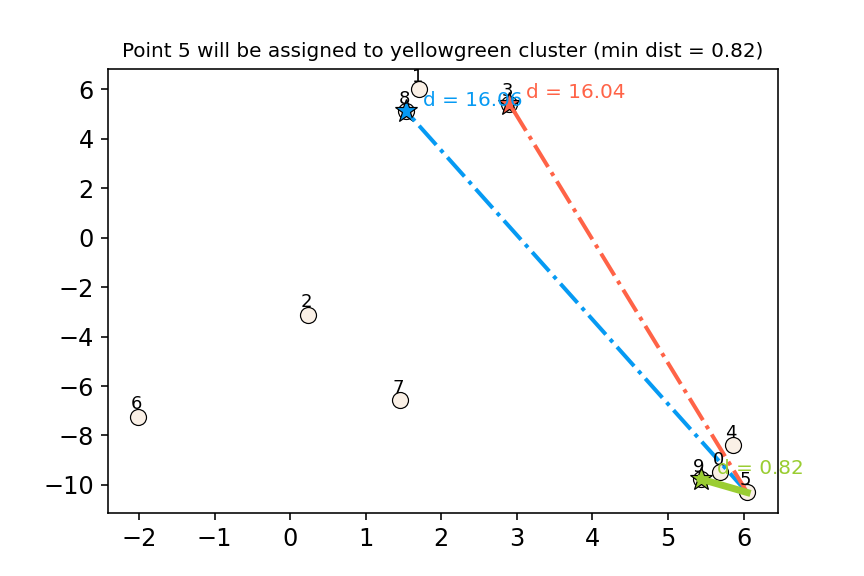
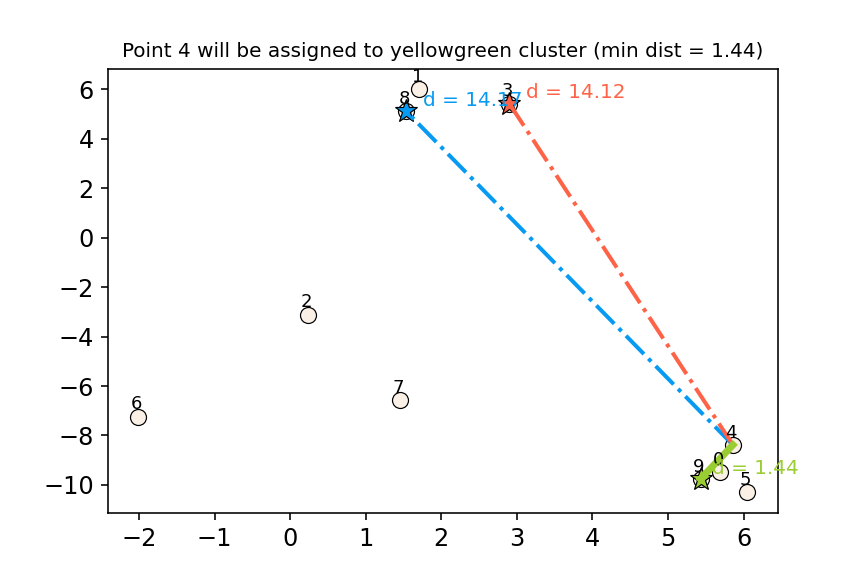
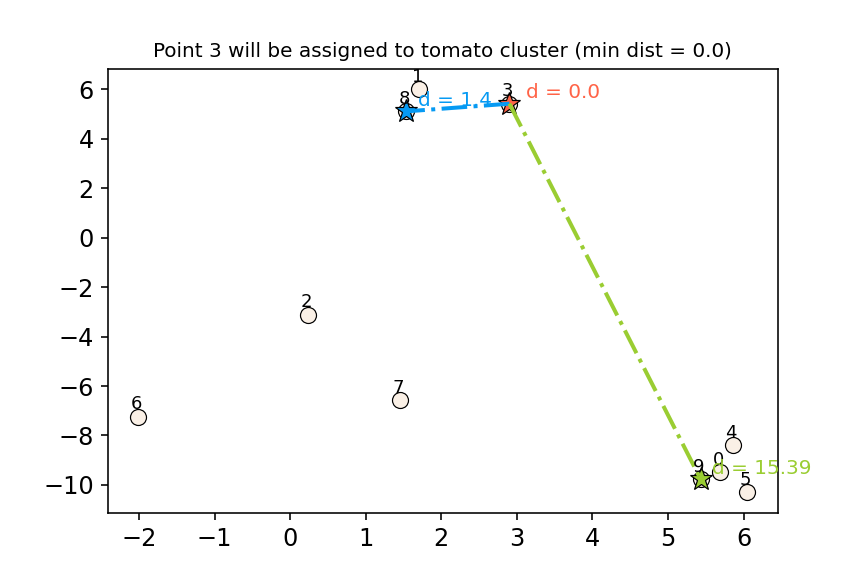
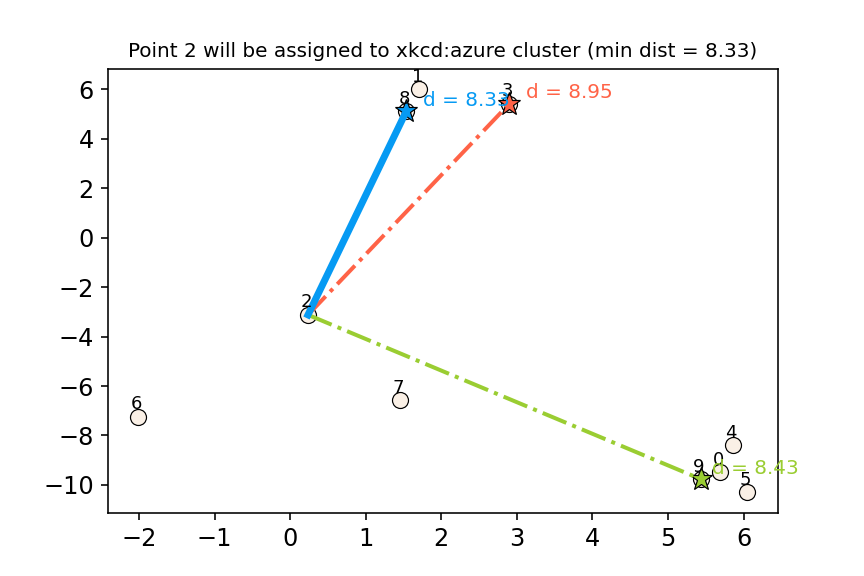
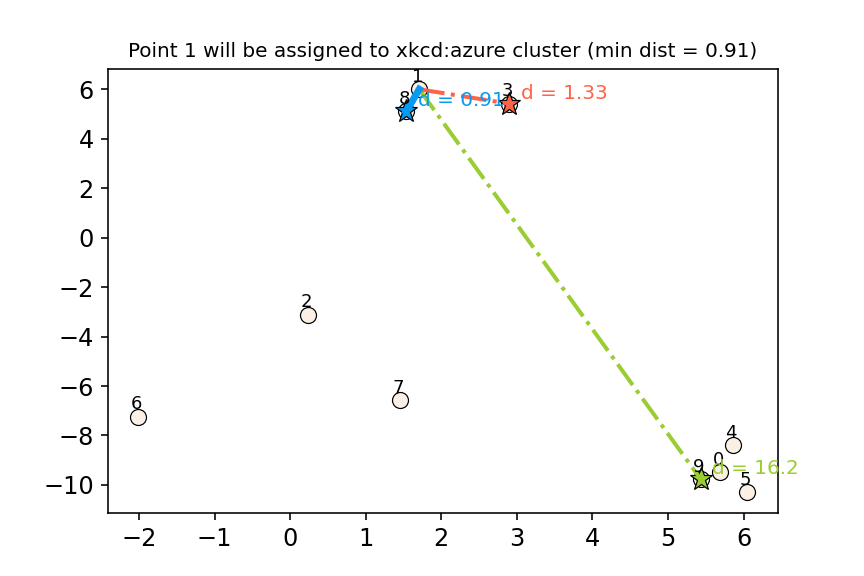
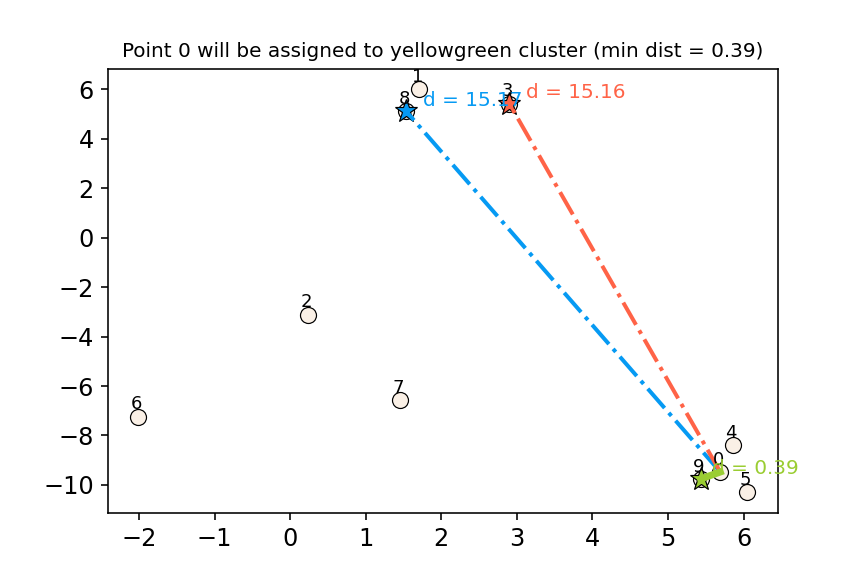

In [17]:
import panel as pn
from panel import widgets
from panel.interact import interact
import matplotlib.pyplot as plt

pn.extension()

def f(point_index):
    fig = plt.figure(figsize=(6, 4))
    # user-defined plotting function defined in code/plotting_functions.py
    return plot_example_dist(X, centers, fig, point_ind=point_index)
    
interact(f, point_index=widgets.FloatSlider(start=0, end=9, step=1, value=0)).embed(max_opts=9)
# interact(f, point_index=widgets.FloatSlider(start=0, end=9, step=1, value=0))

- Similarly, we can make cluster assignments for all points by calculating distances of all examples to the centers and assigning it to the cluster with smallest distance.  

In [18]:
from sklearn.metrics import euclidean_distances

def update_Z(X, centers):
    """
    returns distances and updated cluster assignments
    """
    dist = euclidean_distances(X, centers)
    return dist, np.argmin(dist, axis=1)

- With the new cluster assignments for our data points, we update cluster centers. How do we update centers? 
- New cluster centers are means of data points in each cluster. 

In [19]:
def update_centers(X, Z, old_centers, k):
    """
    returns new centers
    """
    new_centers = old_centers.copy()
    for kk in range(k):
        new_centers[kk] = np.mean(X[Z == kk], axis=0)
    return new_centers

Let's put these steps together. 
- Initialize
- Iteratively alternate between the following two steps.
    - **Update assignments** $Z \rightarrow$ Assign each example to the closest center
    - **Update centers** $\rightarrow$ Estimate new centers as _average_ of examples in a cluster

Let's examine the initial centers. 

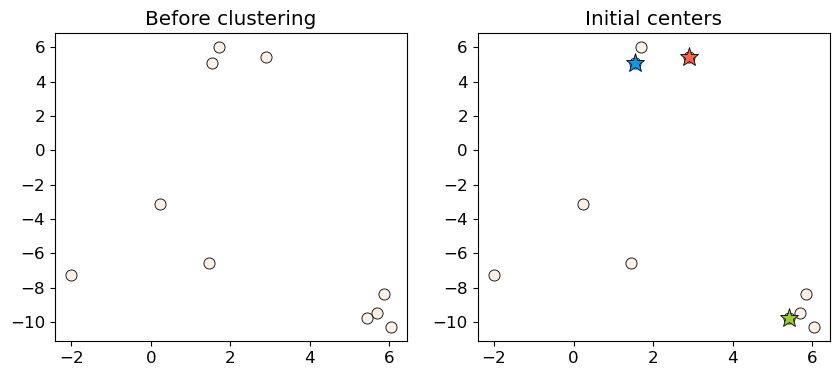

In [20]:
plot_km_initialization(X, centers)

Now let's examine how the assignments and centers change in our toy example.  

Column
    [0] Column
        [0] FloatSlider(end=6, step=1)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00187')
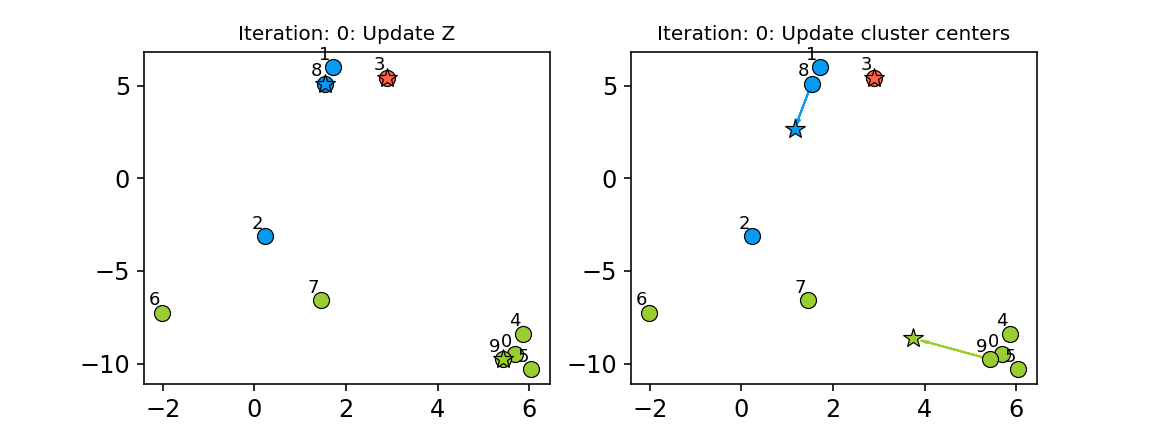

In [21]:
new_centers = X[centers_idx]  
centers = X[centers_idx]

def f(iteration):
    global centers, new_centers
    centers = new_centers.copy()
    dist, Z_km = update_Z(X, centers)    
    new_centers = update_centers(X, Z_km, centers, k)
    fig, ax = plt.subplots(1, 2, figsize=(8, 3)) 
    # user-defined plotting function defined in code/plotting_functions.py
    return plot_km_iteration(X, Z_km, centers, new_centers, iteration, fig, ax)

# interact(f, iteration=widgets.FloatSlider(start=0, end=6, step=1, value=0)).embed(max_opts=11)
interact(f, iteration=widgets.FloatSlider(start=0, end=6, step=1, value=0))

- Seems like after iteration 4 our centroids aren't changing anymore. 
- **The algorithm has converged.** So we stop! 
- K-Means always converges. It doesn't mean it finds the "right" clusters. It can converge to a sub-optimal solution.   

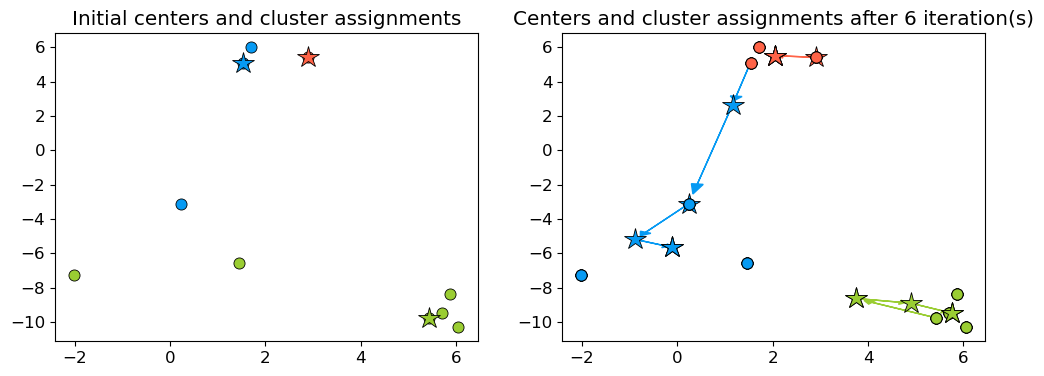

In [22]:
plot_km_iterative(X, X[centers_idx], 6) # user-defined plotting function defined in code/plotting_functions.py

<br><br><br>

### Initialization of K-Means

- The initialization of K-Means is stochastic, can this affect the results?
    - Yes! Big time.  
- Let's look at an example. 

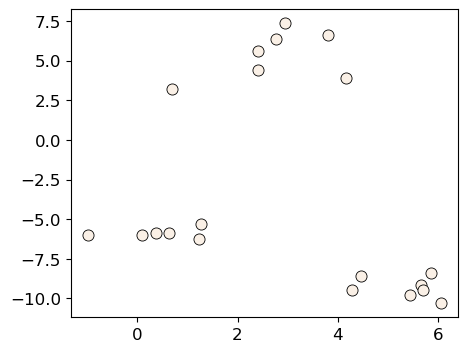

In [23]:
X_init, y_init = make_blobs(n_samples=20, centers=3, n_features=2, random_state=10)
discrete_scatter(X_init[:, 0], X_init[:, 1], markers="o");

In [24]:
k = 3
n_examples = X_init.shape[0]

**Example: Bad initialization**

In [25]:
np.random.seed(seed=10)
centroids_idx_init = np.random.choice(range(0, n_examples), size=k)
centroids = X_init[centroids_idx_init]

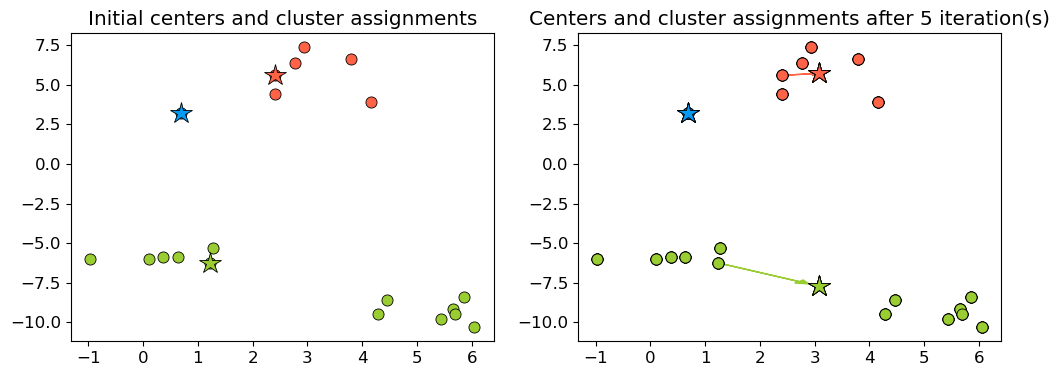

In [26]:
plot_km_iterative(X_init, X_init[centroids_idx_init], 5)

**Example: Better initialization**
The following initialization seems much better. 

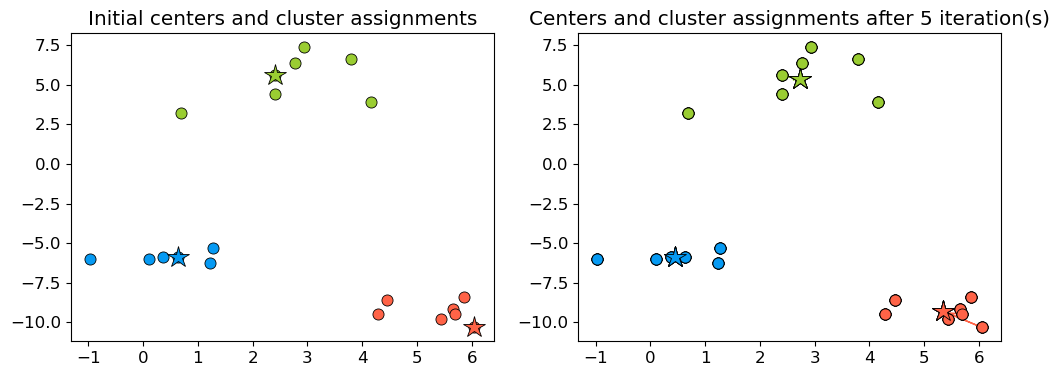

In [27]:
np.random.seed(seed=2)
centroids_idx = np.random.choice(range(0, n_examples), size=k)
plot_km_iterative(X_init, X_init[centroids_idx], 5)

**What can we do about it?**

- One strategy is to run the algorithm several times. 
    - Check out `n_init` parameter of [`sklearn`'s `KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). 
- Is it possible to pick `K` in a smart way? 
    - Yes! We can use the so-called [K-Means++](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf).
    - Intuitively, it picks the initial centroids which are far away from each other. 
    - In other words, K-Means++ gives more chance to select points that are far away from centroids already picked.    
    - By default `sklearn` uses this strategy for initialization. 

<br><br><br>

### ❓❓ Questions for you

**iClicker cloud join link: https://join.iclicker.com/RITY**

### 15.1 Select all of the following statements which are **True** (iClicker)

- (A) K-Means algorithm always converges to the same solution.
- (B) $K$ in K-Means should always be $\leq$ # of features.
- (C) In K-Means, it makes sense to have $K$ $\leq$ # of examples. 
- (D) In K-Means, in some iterations some points may be left unassigned. 

<br><br><br><br>

### 15.2 Select all of the following statements which are **True** (iClicker)

- (A) K-Means is sensitive to initialization and the solution may change depending upon the initialization. 
- (B) K-means terminates when the number of clusters does not increase between iterations.
- (C) K-means terminates when the centroid locations do not change between iterations.
- (D) K-Means is guaranteed to find the optimal solution. 

<br><br><br><br>

## Choosing K [[video](https://youtu.be/M5ilrhcL0oY)]

### Hyperparameter tuning for the number of clusters

- When running K-Means we need to decide the number of clusters in advance (`n_clusters` in `sklearn`). How do we pick this hyperparameter?
- In supervised setting we carried out hyperparameter optimization based on cross-validation scores. 
- Since in unsupervised learning we do not have the target values, it becomes difficult to objectively measure the effectiveness of the algorithms.
- There is no definitive or satisfactory approach.
- However, some strategies might be useful to help you determine K. 

### Method 1: The Elbow method

- This method looks at the sum of **intra-cluster distances**, which is also referred to as **inertia**. 
- The intra-cluster distance in our toy example above is given as   

$$\sum_{P_i \in C_1}  distance(P_i, C_1)^2 + \sum_{P_i \in C_2}  distance(P_i, C_2)^2 + \sum_{P_i \in C_3} distance(P_i, C_3)^2$$

Where 
- $C_1, C_2, C_3$ are centroids 
- $P_i$s are points within that cluster
- $distance$ is the usual Euclidean distance. 

### Inertia 

You can access this intra-cluster distance or inertia as follows. 

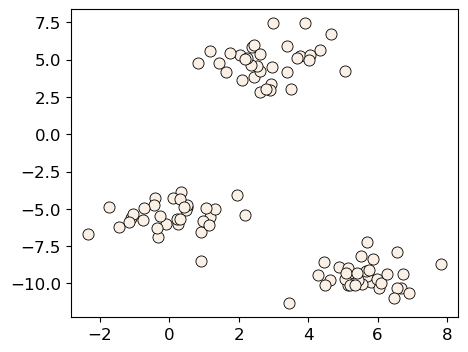

In [28]:
XX, y = make_blobs(centers=3, n_features=2, random_state=10)
discrete_scatter(XX[:, 0], XX[:, 1], markers="o");

In [29]:
d = {"K": [], "inertia": []}
for k in range(1, 100, 10):
    model = KMeans(n_clusters=k, n_init='auto').fit(XX)
    d["K"].append(k)
    d["inertia"].append(model.inertia_)

In [30]:
pd.DataFrame(d)

,K,inertia
0,1,4372.460950
1,11,70.076284
2,21,26.137410
3,31,15.359887
4,41,6.844921
5,51,3.593508
6,61,2.126488
7,71,1.016676
8,81,0.385639
9,91,0.053156


- The inertia decreases as K increases. 
- Question: Do we want inertia to be small or large? 
- The problem is that we can't just look for a $k$ that minimizes inertia because it decreases as $k$ increases.
    - If I have number of clusters = number of examples, each example will have its own cluster and the intra-cluster distance will be 0.  
- Instead we evaluate the trade-off: "small k" vs "small intra-cluster distances". 

In [31]:
def plot_elbow(w, h, inertia_values):
    plt.figure(figsize=(w, h))
    plt.axvline(x=3, linestyle="-.", c="black")
    plt.plot(range(1, 10), inertia_values, "-o")
    ax = plt.gca()
    ax.tick_params("both", labelsize=(w + h))
    ax.set_xlabel("K", fontsize=w+h)
    ax.set_ylabel("Inertia", fontsize=w+h)

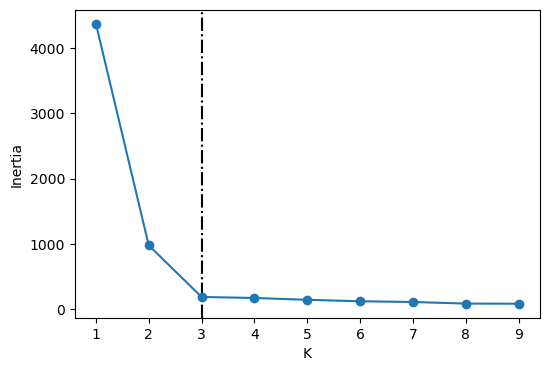

In [32]:
inertia_values = list()
for k in range(1, 10):
    inertia_values.append(KMeans(n_clusters=k, n_init='auto').fit(XX).inertia_)
plot_elbow(6, 4, inertia_values)

- From the above plot, we could argue that three clusters (the point of inflection on the curve) are enough.
- The inertia decreases when clusters are greater than 3. However it's not a big improvement and so we prefer K=3. 
- In this toy example, it's the plot is kind of clear and easy to interpret but it can be hard to interpret in real life examples. 

There is a package called [`yellowbrick`](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) which can be used to create these plots conveniently. 

You can install it as follows: 

`conda install -c districtdatalabs yellowbrick`

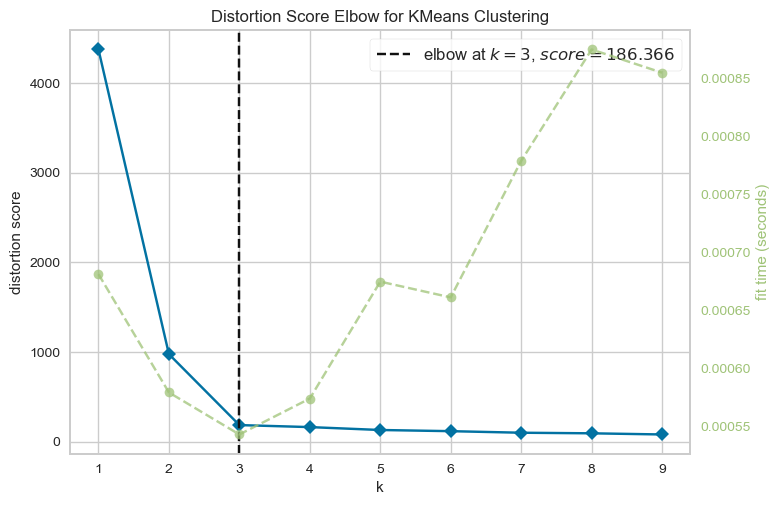

In [33]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=(1, 10))

visualizer.fit(XX)  # Fit the data to the visualizer
visualizer.show();

$s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$

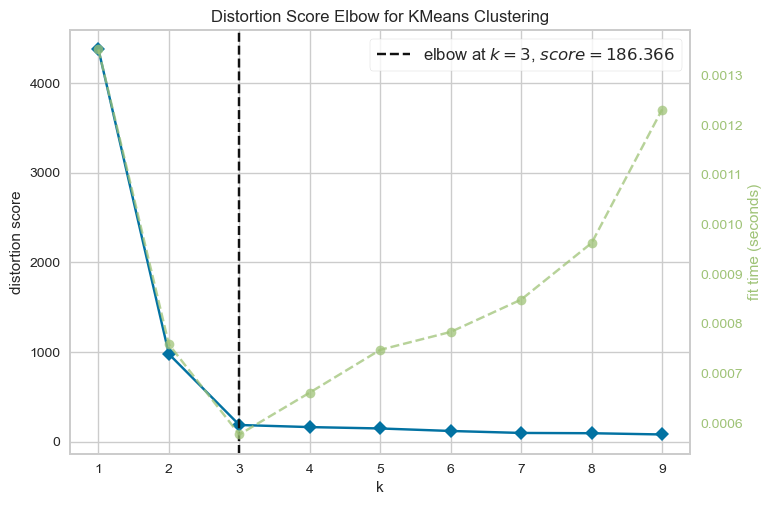

In [34]:
visualizer = KElbowVisualizer(model, k=(1, 10))

visualizer.fit(XX)  # Fit the data to the visualizer
visualizer.finalize();

<br><br>

### Method 2: The Silhouette method

- Not dependent on the notion of cluster centers. 
- Calculated using the **mean intra-cluster distance** ($a$) and the **mean nearest-cluster distance** ($b$) for each sample.

### Mean intra-cluster distance ($a$)

- Suppose the green point below is our sample. 
- Average of the distances of the green point to the other points in the same cluster.
  - These distances are represented by the black lines. 
  

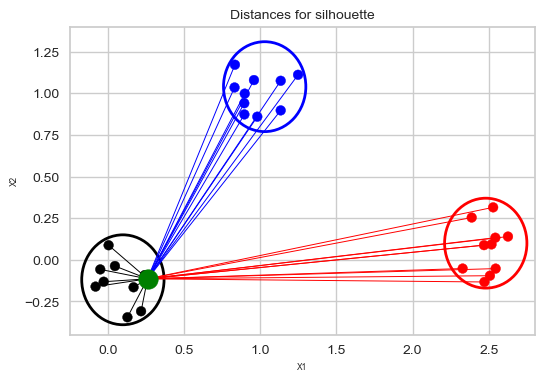

In [35]:
plot_silhouette_dist(6, 4)

### Mean nearest-cluster distance ($b$)

- Average of the distances of the green point to the blue points is smaller than the average of the distances of the green point to the red points. So the **nearest cluster** is the blue cluster. 
- So the mean nearest-cluster distance is the average of the distances of the green point to the blue points.  

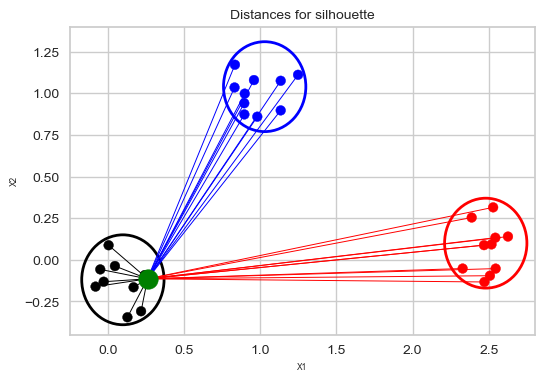

In [36]:
plot_silhouette_dist(6, 4)

### Silhouette distance for a sample 

- the difference between the **the average nearest-cluster distance** ($b$) and **average intra-cluster distance** ($a$) for each sample, normalized by the maximum value

$$\frac{b-a}{max(a,b)}$$

- The best value is 1. 
- The worst value is -1 (samples have been assigned to wrong clusters).
- Value near 0 means overlapping clusters. 

The overall **Silhouette score** is the average of the Silhouette scores for all samples. We can visualize the silhouette score for each example individually in a silhouette plot (hence the name), see below.

### Using Silhouette scores to select the number of clusters

- The plots below show the Silhouette scores for each sample in that cluster. 
- Higher values indicate well-separated clusters. 
- The size of the Silhouette shows the number of samples and hence shows imbalance of data points in clusters.  

In [37]:
from yellowbrick.cluster import SilhouetteVisualizer

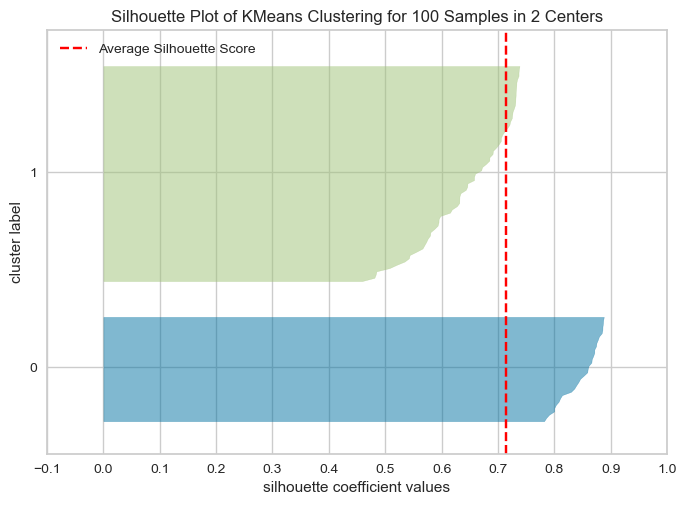

In [38]:
model = KMeans(2, n_init='auto', random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(XX)  # Fit the data to the visualizer
visualizer.show();
# Finalize and render the figure

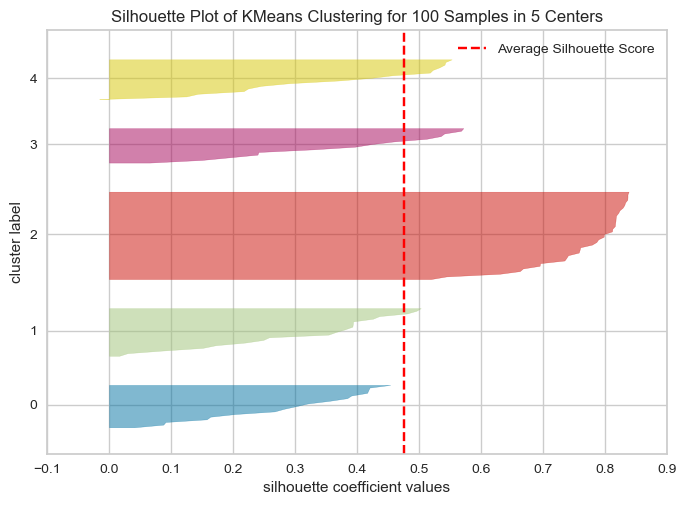

In [39]:
model = KMeans(5, n_init='auto', random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(XX)  # Fit the data to the visualizer
visualizer.show();
# Finalize and render the figure

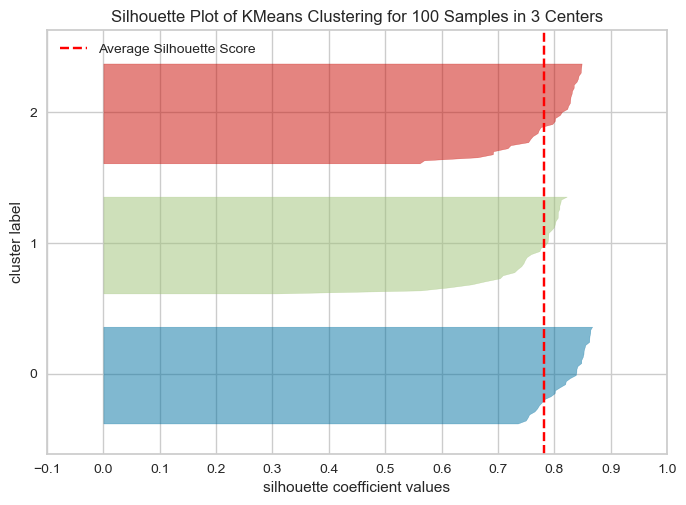

In [40]:
model = KMeans(3, n_init='auto', random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(XX)  # Fit the data to the visualizer
visualizer.show();
# Finalize and render the figure

### What to look for in these plots?

- Unlike inertia, larger values are better because they indicate that the point is further away from neighbouring clusters.
- The thickness of each silhouette indicates the cluster size.
- The shape of each silhouette indicates the "goodness" for points in each cluster.
- The length (or area) of each silhouette indicates the goodness of each cluster.
- A slower dropoff (more rectangular) indicates more points are "happy" in their cluster.
- We can apply Silhouette method to clustering methods other than K-Means. 

<br><br><br><br>

### ❓❓ Questions for you

### 15.3 Select all of the following statements which are **True** (iClicker)

- (A) If you train K-Means with `n_clusters`= the number of examples, the inertia value will be 0. 
- (B) The elbow plot shows the tradeoff between within cluster distance and the number of clusters.
- (C) Unlike the Elbow method, the Silhouette method is not dependent on the notion of cluster centers.
- (D) The elbow plot is not a reliable method to obtain the optimal number of clusters in all cases. 
- (E) The Silhouette scores ranges between -1 and 1 where higher scores indicates better cluster assignments.  

<br><br><br><br>

<br><br><br><br>

## Final comments, summary, and reflection

### Important points to remember

- Clustering is a common unsupervised approach to identify underlying structure in data and grouping points based on similarity. 
- Appropriate data representation is crucial for meaningful clustering. 
- We did not talk much about distance metrics but that is another importance consideration in clustering.
- K-Means is a popular clustering algorithm. 

**Clustering with K-Means**
- It requires us to specify the number of clusters in advance. 
- Each example is assigned to one (and only one) cluster.
- The labels provided by the algorithm have no actual meaning. 
- The centroids live in the same space as of the dataset but they are **not** actual data points, but instead are average points.
- It always converges. Convergence is dependent upon the initial centers and it may converge to a sub-optimal solution. 
- Two popular ways to provide insight into how many clusters are reasonable for the give problem are: **the Elbow method** and **the Silhouette method**.  

- Some applications of clustering include data exploration, feature engineering, customer segmentation, and document clustering. 
- It takes fair amount of manual effort and domain knowledge to interpret clusters returned by clustering models. 

<br><br><br><br>

## Resources 
- ["Spaghetti Sauce" talk by Malcom Gladwell](https://www.ted.com/talks/malcolm_gladwell_on_spaghetti_sauce?language=en)
- [A Comprehensive Survey of Clustering Algorithms](https://link.springer.com/article/10.1007/s40745-015-0040-1)
- [Visualizing-k-means-clustering](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/) 
- [Visualizing K-Means algorithm with D3.js](http://tech.nitoyon.com/en/blog/2013/11/07/k-means/)
- [Clustering with Scikit with GIFs](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/)
- [`sklearn` clustering documentation](https://scikit-learn.org/stable/modules/clustering.html)